In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import argparse
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

!gdown 16rEm1ZvxTGv_2SxM6SEep3QbIelqYzmP
!gdown 1Xyxt1Z4rsswxh3iRPGQcYZDDnDOrHQKR

Downloading...
From: https://drive.google.com/uc?id=16rEm1ZvxTGv_2SxM6SEep3QbIelqYzmP
To: /content/Customer_test.csv
100% 37.9k/37.9k [00:00<00:00, 51.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Xyxt1Z4rsswxh3iRPGQcYZDDnDOrHQKR
To: /content/Customer_train.csv
100% 96.8k/96.8k [00:00<00:00, 4.13MB/s]


In [13]:


train_df = pd.read_csv('Customer_train.csv')
test_df = pd.read_csv('Customer_test.csv')

# Fill missing values in training data
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].median())

cat_cols = train_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

# Separate features and target from training data
X_train = train_df.drop(['ID', 'Segmentation'], axis=1)
y_train = train_df['Segmentation']

# Normalize numerical features in training data
normalizer = Normalizer()
numerical_features = X_train.select_dtypes(include=[np.number]).columns
X_train[numerical_features] = normalizer.fit_transform(X_train[numerical_features])

# Convert categorical variables in training data using LabelEncoder
label_encoders = {}
for column in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train[column] = le.fit_transform(X_train[column])
    label_encoders[column] = le

# Fill missing values in test data
num_cols_test = test_df.select_dtypes(include=['float64', 'int64']).columns
test_df[num_cols_test] = test_df[num_cols_test].fillna(test_df[num_cols_test].median())

cat_cols_test = test_df.select_dtypes(include=['object']).columns
for col in cat_cols_test:
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

# Separate features from test data
X_test = test_df.drop(['ID'], axis=1)

# Normalize numerical features in test data
X_test[numerical_features] = normalizer.transform(X_test[numerical_features])

# Convert categorical variables in test data using the saved LabelEncoders
for column in X_test.select_dtypes(include=['object']).columns:
    if column in label_encoders:
        X_test[column] = label_encoders[column].transform(X_test[column])


# Train One-vs-All Classifier
# ova_classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True))
# ova_classifier.fit(X_train, y_train)

# Train One-vs-One Classifier
ovo_classifier = OneVsOneClassifier(SVC(kernel='linear', probability=True))
ovo_classifier.fit(X_train, y_train)

# Predict labels on the test data using OvA
# y_pred_ova = ova_classifier.predict(X_test)

# Predict labels on the test data using OvO
y_pred_ovo = ovo_classifier.predict(X_test)

# Add predictions to the test DataFrame
# test_df['Predicted_Segmentation_OvA'] = y_pred_ova
test_df['Predicted_Segmentation_OvO'] = y_pred_ovo


Predictions saved to 'ovo.csv'.
Accuracy: 100.00%
Confusion Matrix:
[[489   0]
 [  0 300]]


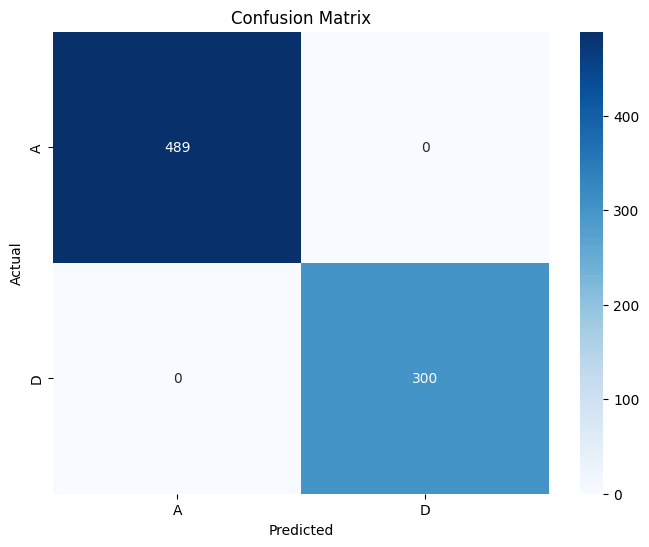

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       489
           D       1.00      1.00      1.00       300

    accuracy                           1.00       789
   macro avg       1.00      1.00      1.00       789
weighted avg       1.00      1.00      1.00       789



In [17]:
# parser = argparse.ArgumentParser(description="One-vs-One (OvO) Classifier for Multi-Class Classification with Support Vector Machines (SVM)")
# parser.add_argument("test_file", help="Path to the test file in the same format as the training data")
# args = parser.parse_args()
# Customer_test = pd.read_csv(args.test_file)
# Customer = pd.read_csv('Customer_train.csv')
# Customer_test = pd.read_csv('Customer_test.csv')

# X = Customer.drop('Segmentation', axis=1)
# y = Customer['Segmentation']
# numeric_column_means = X.select_dtypes(include=['int', 'float']).mean()
# X.fillna(numeric_column_means, inplace=True)
# cat_columns = X.select_dtypes(include=['object'])
# X_encoded = pd.get_dummies(X, columns=cat_columns.columns)

# X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# unique_classes = y_train.unique()

# binary_classifiers = {}

# for pair in itertools.combinations(unique_classes, 2):
#     class1, class2 = pair; binary_y_train = y_train[(y_train == class1) | (y_train == class2)]; binary_X_train = X_train[(y_train == class1) | (y_train == class2)]

#     binary_svc = SVC(kernel='linear', probability=True)
#     binary_svc.fit(binary_X_train, binary_y_train.map({class1: 0, class2: 1}))

#     binary_classifiers[(class1, class2)] = binary_svc

# yhat_test = []

# for i in range(len(X_test)):
#     class_votes = {cls: 0 for cls in unique_classes}

#     for class1, class2 in binary_classifiers:
#         binary_svc = binary_classifiers[(class1, class2)]; prob_class1 = binary_svc.predict_proba(X_test.iloc[i:i+1])[0][0]; prob_class2 = binary_svc.predict_proba(X_test.iloc[i:i+1])[0][1]; class_votes[class1 if prob_class1 > prob_class2 else class2] += 1

#     predicted_class = max(class_votes, key=class_votes.get)
#     # print(predicted_class)
#     yhat_test.append(predicted_class)

from sklearn.base import BaseEstimator, ClassifierMixin, clone
from itertools import combinations
import numpy as np

class CustomOneVsOneClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator):
        """
        Initializes the CustomOneVsOneClassifier.

        Parameters:
        -----------
        estimator : object
            A binary classifier instance (like SVC) that will be used for each "one vs one" task.
        """
        self.estimator = estimator
        self.binary_classifiers_ = {}
        self.classes_ = None

    def fit(self, X, y):
        """
        Fits the OvO classifier for each pair of classes.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training data.

        y : array-like, shape (n_samples,)
            Target values, where each value is the class label for that sample.

        Returns:
        --------
        self : object
            Returns an instance of the classifier.
        """
        self.classes_ = np.unique(y)
        self.binary_classifiers_ = {}

        # Iterate over all pairs of classes
        for class1, class2 in combinations(self.classes_, 2):
            # Select data for the current class pair
            binary_mask = (y == class1) | (y == class2)
            binary_X = X[binary_mask]
            binary_y = y[binary_mask]

            # Map the class labels to 0 and 1 for the binary classification
            binary_y = np.where(binary_y == class1, 0, 1)

            # Clone the estimator and train it on the current binary task
            estimator = clone(self.estimator)
            estimator.fit(binary_X, binary_y)

            # Store the classifier for this class pair
            self.binary_classifiers_[(class1, class2)] = estimator

        return self

    def predict(self, X):
        """
        Predicts the class labels for the input samples X.

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Input data to predict on.

        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Predicted class labels.
        """
        y_pred = []

        # Iterate over each sample in X
        for i in range(X.shape[0]):
            class_votes = {cls: 0 for cls in self.classes_}  # Initialize vote counts for each class

            # Run each binary classifier and update votes based on predictions
            for (class1, class2), estimator in self.binary_classifiers_.items():
                prob_class1 = estimator.predict_proba(X[i:i+1])[0][0]  # Probability for class1
                prob_class2 = estimator.predict_proba(X[i:i+1])[0][1]  # Probability for class2

                # Assign a vote to the class with the higher probability
                if prob_class1 > prob_class2:
                    class_votes[class1] += 1
                else:
                    class_votes[class2] += 1

            # The final prediction is the class with the most votes
            predicted_class = max(class_votes, key=class_votes.get)
            y_pred.append(predicted_class)

        return np.array(y_pred)

    def predict_proba(self, X):
        """
        Predicts probability estimates for each class (based on voting).

        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Input data.

        Returns:
        --------
        proba : array, shape (n_samples, n_classes)
            Predicted probability estimates for each class.
        """
        probas = np.zeros((X.shape[0], len(self.classes_)))

        # Iterate over each sample in X
        for i in range(X.shape[0]):
            class_votes = {cls: 0 for cls in self.classes_}

            # Run each binary classifier and update votes based on probabilities
            for (class1, class2), estimator in self.binary_classifiers_.items():
                prob_class1 = estimator.predict_proba(X[i:i+1])[0][0]
                prob_class2 = estimator.predict_proba(X[i:i+1])[0][1]

                class_votes[class1] += prob_class1
                class_votes[class2] += prob_class2

            # Normalize votes to get probabilities
            total_votes = sum(class_votes.values())
            for cls in self.classes_:
                probas[i, np.where(self.classes_ == cls)] = class_votes[cls] / total_votes

        return probas

# Use SVC as the binary classifier
ovo_classifier_custom = CustomOneVsOneClassifier(SVC(kernel='linear', probability=True))
ovo_classifier_custom.fit(X_train, y_train)

# Predict labels on the test data using the custom OvA
yhat_test = ovo_classifier_custom.predict(X_test)

accuracy = accuracy_score(y_pred_ovo, yhat_test)
predictions_df = pd.DataFrame(data={'predicted': yhat_test})
predictions_df.to_csv('ovo.csv', index=False)
print(f"Predictions saved to 'ovo.csv'.")
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate and display the confusion matrix
conf_matrix = confusion_matrix(y_pred_ovo, yhat_test)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
labels = np.unique(yhat_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate and display the classification report (precision, recall, F1-score)
report = classification_report(y_pred_ovo, yhat_test) #, target_names=y_pred_ovo.unique()) #unique_classes)
print("Classification Report:")
print(report)